<h1 style="color:#191970; font-size:38px">MIMO-NN1</h1>

In [1]:
import numpy as np
from numpy import load
from numpy import save 
from numpy import *
import decimal
from numpy.linalg import inv
from commpy.modulation import QAMModem
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from decimal import getcontext
import matplotlib.pyplot as plt

getcontext().Emax = 600000000000

<h1 style="color:#006400">Functions</h1>

In [2]:
import import_ipynb
from Utils import *

importing Jupyter notebook from Utils.ipynb


<h1 style="color:#006400">Variables</h1>

In [3]:
IBO = 3
p = 1.1
q = 4
Vsat = 1.9
G = 16
A = -345
B = 0.17
Mr = 10
Mt = 100
M = 16
N_bits = Mr * np.log2(M)
SNRdb = decimal.Decimal(60000000000)
Niter = 80
mu1 = 0.0017
lamda = 0.00071
mu2 = 1
eps = 1e-2

<h1 style="color:#006400">Initialization</h1>

In [4]:
N_bits = Mr * np.log2(M)
MSE = np.zeros((Mt, 50))
x_gd_amp0 = np.zeros((Mt, 1))
y_gd_r0 = np.zeros([10000, 100])
PAPR_GD = np.zeros((Mt, 1))
MUIgdi = np.zeros((Mt, 1))
SERgdi = np.zeros((10000, 1))
BERgdi = np.zeros((10000, 1))
x_gd = np.zeros([Mt, 1])
gdx1 = np.zeros([Mt, Niter])
d = np.zeros([Mt, 1])
S = np.zeros((10000, 20))
ZZ = np.zeros((10000, 10), dtype=complex)
X = np.zeros((10000, 200))
IH1=np.zeros((300, 2000))
OH1=np.zeros((300, 4620))
MSEgd=np.zeros((1000,1))

<h1 style="color:#006400">Basic_Nonlinear_Distortion_Model</h1>

In [5]:
K0, sigma_2d = Basic_Nonlinear_Distortion_Model(A, B, q, p, G, Vsat, IBO)

<h1 style="color:#006400"> Data </h1>

In [6]:
""" Generate the matrix of the channel H ∈ ℂ(Mr * Mt) whose inputs are complex random Gaussian variables
    Transfer H Matrix into a vector that contains H Real values concatenated with H Imaginary values  """
for t in range(300):
    H = (1 / np.sqrt(2 * Mt)) * (np.random.randn(Mr, Mt) + 1j * np.random.randn(Mr, Mt))
    HR = H.flatten()
    realh = np.real(HR)
    imagh = np.imag(HR)
    Hr = np.concatenate((realh, imagh), axis=0).reshape(-1, 1)
    Hr = np.reshape(Hr, (2000, 1)).T
    HH = Hr
    HH.tolist()
    """Generate for each H; 10,000 symbols Z and 10,000 precoded symbols X by
    Generating a random bit stream equivalent to the transmissed signal then modulating this bit stream (16-QAM type modulation) using the QAMModem () function of the CommPy library
    Concatenate Z real part with Z imaginary part into S vector its size is (10000,20)
    Compute the gradient gradient in order to have X_gd which, when ampliﬁed and then passed through the channel, can guarantee excellent transmission quality.  
    The vector X contains precoded real symbols concatenated with the imaginary ones.
    Then update IBO Coefficients where Input Back-Off in a power amplifier, is a measure of how far you must reduce the input power in order to receive the desired output linearity and power.
    Determine the distortion vector (d) and the PA Gain complex (K0) using hpa_sspa_modif_rapp() and find_K0_sigma2_d() functions.
    Where Vin and Vout are the input / output of Power amplifier PA."""
    for j in range(10000):
        bits = np.random.randint(2, size=int(N_bits))  
        QAM16 = QAMModem(16)  
        z = QAM16.modulate(bits)
        Z = np.reshape(z, (1, 10)).T
        ZZ[j] = Z.T
        reals = np.real(Z.T)
        imags = np.imag(Z.T)
        s = np.concatenate((reals, imags), axis=1)
        S[j] = s
        for i in range(Niter):
            gdx1 = 2 * np.conj(K0 * np.transpose(H)).dot(K0 * H.dot(x_gd) + H.dot(d) - Z)
            x_gd = x_gd - mu1 * gdx1
            realx = np.real(x_gd)
            imagx = np.imag(x_gd)
            x_z = np.concatenate((realx, imagx), axis=0).T
            X[j] = x_z
            val_IBO_m1dB = (
                ((1 / np.sqrt(10 ** -0.1)) ** (2 * p) - 1) ** (1 / (2 * p)) * Vsat / (G)
            )
            coeff_IBO_m1dB = (
                val_IBO_m1dB * np.sqrt((1 / np.var(x_gd))) * np.sqrt(10 ** (-IBO / 10))
            )  
            vin2 = coeff_IBO_m1dB * x_gd
            vout2 = hpa_sspa_modif_rapp(
                vin2, Vsat, p, q, G, A, B
            ) 
            K0, sigma2_d = find_K0_sigma2_d(vin2, vout2)
            d = vout2 - K0 * vin2  
            y_gd =vout2 / coeff_IBO_m1dB
            MSEgd=np.mean(np.abs(H.dot(y_gd) - Z) ** 2) / (np.mean(np.abs(Z) ** 2))
        NMSEGD = 10 * np.log10(np.mean(MSEgd))
    print('nmsede GD',NMSEGD)
    "Base d'apprentissage"
    X_train = S[:9000, :]
    y_train = X[:9000, :]
    "Base de test"
    X_test = S[9000:, :]
    y_test = X[9000:, :]
    """Create NN1 Model which contains 2 hidden layers; The first layer have 20 neurones and the second have 200 neurones  """
    model=Sequential()
    model.add(Dense(units=20, kernel_initializer="uniform", activation="linear", input_dim=20))
    model.add(Dense(units=200, kernel_initializer="uniform", activation="linear"))
    model.compile(optimizer="Adamax", loss="mae", metrics=['mse'])
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        batch_size=1000,
        epochs=600,
        shuffle=True,
    )
    #Make predictions 
    y_pred = model.predict(X_train)
    y_predt = model.predict(X_test)
    
    # Calculate NMSE of NN1
    NMSE = np.zeros([1000, 1])
    recievehh = np.zeros([1000, 10], dtype=complex)
    Y_gdr = y_predt[:1000, :100]
    Y_gdi = 1j * y_predt[:1000, 100:]
    Y_gd = Y_gdr + Y_gdi
    Shr = X_test[:1000, :10]
    Shi = 1j * X_test[:1000, 10:20]
    SSh = Shr + Shi
    for i in range(1000):
        val_IBO_m1dB = (
            ((1 / np.sqrt(10 ** -0.1)) ** (2 * p) - 1) ** (1 / (2 * p)) * Vsat / (G)
        )
        coeff_IBO_m1dB = (
            val_IBO_m1dB * np.sqrt((1 / np.var(Y_gd[i]))) * np.sqrt(10 ** (-IBO / 10))
        )
        vin2 = coeff_IBO_m1dB * Y_gd[i]
        vout2 = hpa_sspa_modif_rapp(vin2, Vsat, p, q, G, A, B)
        Y_gd_amp = vout2 / coeff_IBO_m1dB
        recieveh = (H.dot(Y_gd_amp)).reshape((10))
        recievehh[i] = recieveh
        NMSE[i] = np.mean(np.abs(SSh[i] - recieveh) ** 2) / np.mean(np.abs(SSh[i]) ** 2)
    NMSEdb = 10 * np.log10(np.mean(NMSE))
    print(NMSEdb )
    if NMSEdb< -32 :
        """ Recover the weight vector of our model NN1 using the function get_weights ().
        This vector will be the desired output of the NN2 model."""
        first_layer_weights =model.layers[0].get_weights()[0] 
        first=first_layer_weights.flatten()
        first_layer_biases  = model.layers[0].get_weights()[1]
        first_layer=np.concatenate((first,first_layer_biases),axis=0)
        second_layer_weights = model.layers[1].get_weights()[0]
        second=second_layer_weights.flatten()
        second_layer_biases  = model.layers[1].get_weights()[1]
        second_layer=np.concatenate((second,second_layer_biases),axis=0)
        weights=np.concatenate((first_layer,second_layer),axis=0)
        weights.tolist()
        print (t)
        #IH1 contains Channel vectors that will saved into an npy file
        IH1[t]=HH
        save('dataI01.npy',IH1)
        #OH1 contains Weight vectors that will saved into an npy file
        OH1[t]=weights
        save('dataO01.npy',OH1)
        
        print('canal numero ',t,'Saved')
    else:
        print('canal numero ',t,'Condition not satisfied')

nmsede GD -40.58415502756648
Epoch 1/600
9/9 [==============================] - 0s 13ms/step - loss: 0.0465 - mse: 0.0035 - val_loss: 0.0421 - val_mse: 0.0029
Epoch 2/600
9/9 [==============================] - 0s 5ms/step - loss: 0.0397 - mse: 0.0025 - val_loss: 0.0373 - val_mse: 0.0023
Epoch 3/600
9/9 [==============================] - 0s 4ms/step - loss: 0.0356 - mse: 0.0021 - val_loss: 0.0338 - val_mse: 0.0019
Epoch 4/600
9/9 [==============================] - 0s 3ms/step - loss: 0.0323 - mse: 0.0017 - val_loss: 0.0307 - val_mse: 0.0015
Epoch 5/600
9/9 [==============================] - 0s 3ms/step - loss: 0.0292 - mse: 0.0014 - val_loss: 0.0276 - val_mse: 0.0013
Epoch 6/600
9/9 [==============================] - 0s 4ms/step - loss: 0.0262 - mse: 0.0011 - val_loss: 0.0247 - val_mse: 0.0010
Epoch 7/600
9/9 [==============================] - 0s 3ms/step - loss: 0.0234 - mse: 9.2361e-04 - val_loss: 0.0220 - val_mse: 8.2361e-04
Epoch 8/600
9/9 [==============================] - 0s 3ms/s

KeyboardInterrupt: 

In [20]:

""" Save S transmitted symbols vector and X precoded symbols vector in datas.npy and datax.npy files """
from numpy import load

Ih=load('IH.npy')[np.nonzero(load('IH.npy' ))]
Oh=load('OH.npy')[np.nonzero(load('OH.npy' ))]
Ih1=load('IH1.npy')[np.nonzero(load('IH1.npy'))]
Oh1=load('OH1.npy')[np.nonzero(load('OH1.npy'))]
Ih2=load('dataIHC.npy')[np.nonzero(load('dataIHC.npy' ))]
Oh2=load('dataOHC.npy')[np.nonzero(load('dataOHC.npy' ))]
IH2=load('IH2.npy')[np.nonzero(load('IH2.npy' ))]
OH2=load('OH2.npy')[np.nonzero(load('OH2.npy' ))]
Ih3=load('IH3.npy')[np.nonzero(load('IH3.npy'))]
Oh3=load('OH3.npy')[np.nonzero(load('OH3.npy'))]
Ih4=load('IH4.npy')[np.nonzero(load('IH4.npy' ))]
Oh4=load('OH4.npy')[np.nonzero(load('OH4.npy' ))]
Ih5=load('IH5.npy')[np.nonzero(load('IH5.npy' ))]
Oh5=load('OH5.npy')[np.nonzero(load('OH5.npy' ))]


# Duplicate IHH matrix which contains the association of all channel vectors
IHH=np.concatenate((Ih,Ih1,IH2,Ih4,Ih3),axis=0)
IHHH=np.concatenate((IHH,np.copy(IHH)),axis=0)
# Duplicate OHH matrix which contains the association of all weight vectors

OHH=np.concatenate((Oh,Oh1,OH2,Oh4,Oh3),axis=0)
OHHH=np.concatenate((OHH,np.copy(OHH)),axis=0)

IHHH=IHHH.reshape((2378,2000))
OHHH=OHHH.reshape((2378,4620))
print(IHHH.shape)    
print(OHHH.shape)
"Base d'apprentissage de NN2"
X_trainN2 = IHHH[:1578,:]
y_trainN2 = OHHH[:1578,:]
"Base de test de NN2"
X_testN2= IHHH[1578:,:]
y_testN2 = OHHH[1578:,:]

(2378, 2000)
(2378, 4620)


Epoch 1/1000
2/2 [==============================] - 0s 81ms/step - loss: 0.0976 - mse: 0.0158 - val_loss: 0.0915 - val_mse: 0.0143
Epoch 2/1000
2/2 [==============================] - 0s 64ms/step - loss: 0.0892 - mse: 0.0138 - val_loss: 0.0866 - val_mse: 0.0132
Epoch 3/1000
2/2 [==============================] - 0s 60ms/step - loss: 0.0837 - mse: 0.0125 - val_loss: 0.0828 - val_mse: 0.0123
Epoch 4/1000
2/2 [==============================] - 0s 63ms/step - loss: 0.0795 - mse: 0.0116 - val_loss: 0.0797 - val_mse: 0.0116
Epoch 5/1000
2/2 [==============================] - 0s 68ms/step - loss: 0.0761 - mse: 0.0109 - val_loss: 0.0770 - val_mse: 0.0110
Epoch 6/1000
2/2 [==============================] - 0s 58ms/step - loss: 0.0732 - mse: 0.0103 - val_loss: 0.0747 - val_mse: 0.0105
Epoch 7/1000
2/2 [==============================] - 0s 59ms/step - loss: 0.0707 - mse: 0.0097 - val_loss: 0.0727 - val_mse: 0.0101
Epoch 8/1000
2/2 [==============================] - 0s 61ms/step - loss: 0.0686 - m

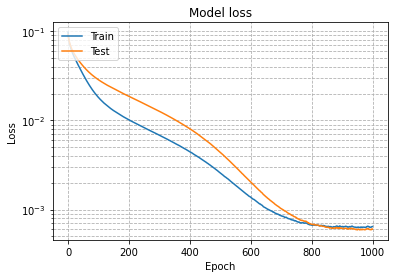

In [14]:
"""Create NN2 Model which contains 2 hidden layers; 
The first layer have 1000 neurones (input_dim=2000)
The second have 4620 neurones (output_dim=4620) """
modell=Sequential()
modell.add(Dense(units=1000, kernel_initializer="uniform", activation="linear", input_dim=2000))
modell.add(Dense(units=4620, kernel_initializer="uniform", activation="linear"))
modell.compile(optimizer="Adamax", loss="mae", metrics=['mse'])
history2 = modell.fit(X_trainN2,y_trainN2,validation_data=(X_testN2, y_testN2),batch_size=1000,epochs=1000,shuffle=True)
# Loss representation
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.grid(True,which="both", linestyle='--')
plt.ylabel('Loss') 
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper left')
plt.show()
# Make predictions
y_pred = modell.predict(X_trainN2)
y_predt = modell.predict(X_testN2)


In [17]:
pip install sklearn

     |################################| 6.9MB 21.8MB/s eta 0:00:01     |#####                           | 1.3MB 21.8MB/s eta 0:00:01
     |################################| 307kB 101.1MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=b33c709b0c1b1f2687dd10844e1b5a1f0e0be0ae8af456e125019a22d87aa383
  Stored in directory: /root/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


0.1014569622825134

ERR 0.0035648317303074196
mae 0.0006591027817140965


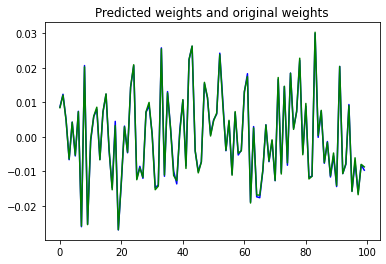

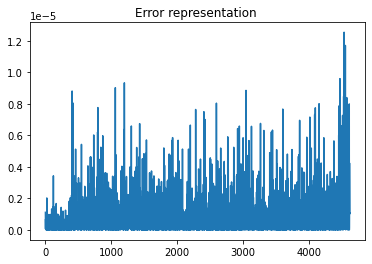

In [33]:

"Tests"
import sklearn.metrics
from sklearn.metrics import mean_absolute_error
#Test1 pour H donnée
Ih5=Ih5.reshape((352,2000))
Oh5=Oh5.reshape((352,4620))
y_predt1 = modell.predict(Ih5[:1,:])
print(mean_absolute_error(y_predt1[:1,:],Oh5[:1,:]))

#Test3 pour H du NN2
y_predt11 = modell.predict(X_testN2[:1,:])
print()
plt.figure()
plt.title('Predicted weights and original weights')
plt.plot(y_predt[1,:100],'b')
plt.plot(y_testN2[1,:100],'g')
ERR=(abs(y_predt[10,:]-y_testN2[10,:])**2)
print('ERR',sum(ERR))
mae=mean_absolute_error(y_predt11[:1,:],y_testN2[:1,:])
print('mae',mae)
plt.figure()
plt.title('Error representation ')
plt.plot(ERR)


In [22]:
""" Recover the weight vector predicted bu NN2 using the function get_weights ()"""
first_layer_weightstt=y_predt[:,:400]
first_layer_biasestt=y_predt[:,400:420]

second_layer_weightstt=y_predt[:,420:4420]
second_layer_biasestt=y_predt[:,4420:]

## Predected weights

In [23]:
"""Re-Create NN1 with predicted weights and calculate NMSE """
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
for t in range(800):
    H2r=X_testN2[t,:1000]
    H2i=1j*X_testN2[t,1000:]
    H02=H2r+H2i
    H2=H02.reshape((10,100))
    print('Canal numero:',t)
    S_NN1 =X_test[:800,:]
    modelll=Sequential()
    modelll.add(Dense(units=20, kernel_initializer="uniform", activation="relu", input_dim=20))
    first_weightstt=first_layer_weightstt[t,:400]
    L1=first_weightstt.reshape((20,20))
    first_layer_biasestt=y_predt[t,400:420]
    L2=first_layer_biasestt
    modelll.layers[0].set_weights([L1,L2])
    modelll.add(Dense(units=200, kernel_initializer="uniform", activation="linear"))
    second_weightstt=y_predt[t,420:4420]
    L3=second_weightstt.reshape((20,200))
    second_layer_biasestt=y_predt[t,4420:4620]
    L4=second_layer_biasestt
    modelll.layers[1].set_weights([L3,L4]) 
    NMSE2 = np.zeros((800, 1))
    y_predt2 = modelll.predict(S_NN1)
    Y_gd2r = y_predt2[:800,:100]
    Y_gd2i = 1j * y_predt2[:800,100:]
    Y_gd2 = Y_gd2r + Y_gd2i
    print(Y_gd2.shape)
    Shr2 = S_NN1[:800, :10]
    Shi2 = 1j * S_NN1[:800, 10:20]
    SSh2 = Shr2 + Shi2
    for n in range(800):
        coeff_IBO_m1dB22=val_IBO_m1dB * np.sqrt((1 / np.var(Y_gd2[n]))) * np.sqrt(10 ** (-IBO / 10))
        vin222 = coeff_IBO_m1dB22 * Y_gd2[n]
        vout222 = hpa_sspa_modif_rapp(vin222, Vsat, p, q, G, A, B)
        Y_gd_amp2 = vout222 / coeff_IBO_m1dB22
        recieveh2 = (H2.dot(Y_gd_amp2)).reshape((10))
        NMSE2[n]= np.mean(np.abs(SSh2[n] - recieveh2) ** 2) / np.mean(np.abs(SSh2[n]) ** 2)
    NMSE2db = 10 * np.log10(np.mean(NMSE2)) 
    print('NMSE de canal numero',t ,'est: ',NMSE2db) 
    print('MAE',mean_absolute_error(y_predt[t,:],y_testN2[t,:]))
       


Canal numero: 0
(800, 100)
NMSE de canal numero 0 est:  -22.172042467849966
MAE 0.0006591021333160312
Canal numero: 1
(800, 100)
NMSE de canal numero 1 est:  -23.97351154884526
MAE 0.0005234120044256541
Canal numero: 2
(800, 100)
NMSE de canal numero 2 est:  -22.793703036987047
MAE 0.0006530899475526429
Canal numero: 3
(800, 100)
NMSE de canal numero 3 est:  -21.915557274699147
MAE 0.0006600882978847193
Canal numero: 4
(800, 100)
NMSE de canal numero 4 est:  -23.419157730264093
MAE 0.0005409063975400988
Canal numero: 5
(800, 100)
NMSE de canal numero 5 est:  -22.576666469219195
MAE 0.0006191488549124487
Canal numero: 6
(800, 100)
NMSE de canal numero 6 est:  -22.331163238025518
MAE 0.0006222046001702048
Canal numero: 7
(800, 100)
NMSE de canal numero 7 est:  -24.007138975734303
MAE 0.0005297559185052284
Canal numero: 8
(800, 100)
NMSE de canal numero 8 est:  -23.634335978990293
MAE 0.0005552834970862401
Canal numero: 9
(800, 100)
NMSE de canal numero 9 est:  -23.514696956303393
MAE 0.0

KeyboardInterrupt: 

## origin weights 

In [24]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
for t in range(800):
    H2r=X_testN2[t,:1000]
    H2i=1j*X_testN2[t,1000:]
    H02=H2r+H2i
    H2=H02.reshape((10,100))
    print('Canal numero:',t)
    S_NN1 =X_test[:800,:]
    modelll=Sequential()
    modelll.add(Dense(units=20, kernel_initializer="uniform", activation="relu", input_dim=20))
    first_weightsttV=y_testN2[t,:400]
    LV1=first_weightsttV.reshape((20,20))
    first_layer_biasesttV=y_testN2[t,400:420]
    LV2=first_layer_biasesttV
    modelll.layers[0].set_weights([LV1,LV2])
    modelll.add(Dense(units=200, kernel_initializer="uniform", activation="linear"))
    second_weightsttV=y_testN2[t,420:4420]
    LV3=second_weightsttV.reshape((20,200))
    second_layer_biasesttV=y_testN2[t,4420:4620]
    LV4=second_layer_biasesttV
    modelll.layers[1].set_weights([LV3,LV4]) 
    y_predt2 = modelll.predict(S_NN1)
    NMSE2 = np.zeros((800, 1))
    Y_gd2r = y_predt2[:800,:100]
    Y_gd2i = 1j * y_predt2[:800,100:]
    Y_gd2 = Y_gd2r + Y_gd2i
    print(Y_gd2.shape)
    Shr2 = S_NN1[:800, :10]
    Shi2 = 1j * S_NN1[:800, 10:20]
    SSh2 = Shr2 + Shi2
    for n in range(800):
        coeff_IBO_m1dB22=val_IBO_m1dB * np.sqrt((1 / np.var(Y_gd2[n]))) * np.sqrt(10 ** (-IBO / 10))
        vin222 = coeff_IBO_m1dB22 * Y_gd2[n]
        vout222 = hpa_sspa_modif_rapp(vin222, Vsat, p, q, G, A, B)
        Y_gd_amp2 = vout222 / coeff_IBO_m1dB22
        recieveh2 = (H2.dot(Y_gd_amp2)).reshape((10))
        NMSE2= np.mean(np.abs(SSh2[n] - recieveh2) ** 2) / np.mean(np.abs(SSh2[n]) ** 2)
        NMSE2db = 10 * np.log10(np.mean(NMSE2)) 
    print('NMSE de canal numero',t ,'est: ',NMSE2db) 

Canal numero: 0
(800, 100)
NMSE de canal numero 0 est:  -25.335268252593913
Canal numero: 1
(800, 100)
NMSE de canal numero 1 est:  -27.404197495898476
Canal numero: 2
(800, 100)
NMSE de canal numero 2 est:  -27.586082487913576
Canal numero: 3
(800, 100)
NMSE de canal numero 3 est:  -25.84907980853306
Canal numero: 4
(800, 100)
NMSE de canal numero 4 est:  -24.705768876646097
Canal numero: 5
(800, 100)
NMSE de canal numero 5 est:  -26.93462241809922
Canal numero: 6
(800, 100)
NMSE de canal numero 6 est:  -24.291133620848715
Canal numero: 7
(800, 100)
NMSE de canal numero 7 est:  -26.919582320941217
Canal numero: 8
(800, 100)
NMSE de canal numero 8 est:  -27.48167328870643
Canal numero: 9
(800, 100)
NMSE de canal numero 9 est:  -25.98361021894281
Canal numero: 10
(800, 100)
NMSE de canal numero 10 est:  -26.612938232507414
Canal numero: 11
(800, 100)
NMSE de canal numero 11 est:  -28.324986101415426
Canal numero: 12
(800, 100)
NMSE de canal numero 12 est:  -25.478794364909643
Canal nume

KeyboardInterrupt: 